# Image classification of CIFAR-10 dataset using vision transformer architecture.


## The entire code is divided into 6 sections:
### 1. Importing the libraries
### 2. Pre-processing and loading the dataset
### 3. Building the model
### 4. Training the model
### 5. Visualizing the Output
### 6. Prediction
--------------------------------------------------------------------------------------------


In [ ]:
# 1. Importing the Libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
%matplotlib inline
import os
import socket

#recognizing the CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#setting up directory
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/studienarbeit")
if torch.cuda.is_available():
    print(f'GPU : {torch.cuda.get_device_name(device=device)}')
print(f'CPUs: {torch.get_num_threads()}, GPUs: {torch.cuda.device_count()} on {socket.gethostname()}.')

Mounted at /content/drive
GPU : Tesla T4
CPUs: 1, GPUs: 1 on 7bb8dbf8a0bc.


In [ ]:
# 2. Preprocessing and loading the data

# preparatory to load dataset
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5)) ])
trainset = torchvision.datasets.CIFAR10('./data', train = True, transform = transform, download = True)
testset = torchvision.datasets.CIFAR10('./data',  transform = transform, download = True) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


#### Lets Visulise few images from a batch in dataloader

In [ ]:
'''
we can iterate over different batches in the data loader. it contains batches as lists. 
each batch is a list of two tensors. first tensor contains batch no. of images, second tensor contains
batch no. of lables. 
'''
batch = iter(trainloader).next()
data = batch[0]
labels = batch[1]
print(type(batch))

print(batch[0].shape, batch[1].shape)
print(batch[0][1])


<class 'list'>
torch.Size([128, 3, 32, 32]) torch.Size([128])
tensor([[[ 0.0667, -0.3412, -0.1608,  ...,  0.0275, -0.1451,  0.0667],
         [-0.0667, -0.4431, -0.1608,  ...,  0.1059,  0.2314,  0.2314],
         [-0.3569, -0.5843, -0.5216,  ...,  0.1451,  0.1451,  0.1294],
         ...,
         [-0.5059, -0.5137, -0.4980,  ..., -0.3961, -0.3882, -0.4196],
         [-0.4745, -0.4588, -0.4431,  ..., -0.5765, -0.5059, -0.5137],
         [-0.5686, -0.5451, -0.5137,  ..., -0.6627, -0.6471, -0.6392]],

        [[ 0.0039, -0.4980, -0.3725,  ..., -0.2392, -0.3098, -0.0667],
         [-0.1765, -0.5137, -0.3020,  ..., -0.0431, -0.0431,  0.0588],
         [-0.5216, -0.6627, -0.6392,  ..., -0.0275, -0.0745, -0.0667],
         ...,
         [-0.2235, -0.2314, -0.2157,  ..., -0.0667, -0.0588, -0.0902],
         [-0.1922, -0.1529, -0.1451,  ..., -0.3647, -0.2392, -0.2314],
         [-0.3098, -0.2549, -0.2157,  ..., -0.4902, -0.4588, -0.4588]],

        [[-0.6314, -0.7412, -0.6863,  ..., -0.6863, -0

In [ ]:
# model
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model = None,  patch_amount = None):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(patch_amount, d_model)
        position = torch.arange(0, patch_amount, dtype=torch.float).unsqueeze(1)
        div_term = 10000.0**-(torch.arange(0,d_model,2)/(d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return x

class Network(nn.Module):
    
    def __init__(self, patch_size=None, Image_size = None, channels = None,d_model=128, layers=1, nhead=32, dim_feedforward=256, dropout=0.15):
        super().__init__()
        
        # patch to embedding
        self.embedding = nn.Linear(patch_size*patch_size*channels,d_model)

        # positional encoding ( use "sine-cosine" or "learnable randomnumber" positional encoding)      

        patch_amount = int((Image_size/patch_size)**2)
        #self.pos_enc = PositionalEncoding(d_model = d_model, patch_amount = patch_amount) # sine and cosine encoding
        self.pos_enc = nn.Parameter(torch.rand(1,patch_amount,d_model)) # learnable position encoding
        
        # Transformer encoder block
        layer_list = []
        for layer in range(layers):
          layer_list += [torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)]
        self.encoder = torch.nn.Sequential(*layer_list)
        # MLP on top of Transformer encoder block
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 10),
        )
                                
    def forward(self, x):
        
        x = self.embedding(x)
        #x = self.pos_enc(x)
        x += self.pos_enc
        x = self.encoder(x)   
        x = self.classifier(x.max(dim=1)[0])
        return x

    def save_model(self, name):
        torch.save(self.state_dict(), name)

Image_size = 32 # image size
patch_size = 8 # patch size
channels = 3
mymodel = Network(patch_size= patch_size, Image_size = Image_size, channels = channels, d_model = 512, layers= 5, nhead = 32, dim_feedforward = 256, dropout=0.15)
print(mymodel)
mymodel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
print(f'Number of parameters: {sum(p.numel() for p in mymodel.parameters()):,}')

Network(
  (embedding): Linear(in_features=192, out_features=512, bias=True)
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=256, bias=True)
      (dropout): Dropout(p=0.15, inplace=False)
      (linear2): Linear(in_features=256, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.15, inplace=False)
      (dropout2): Dropout(p=0.15, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=256, bias=True)
      (dropout): Dropout(p=0.15, inplace=False)
      (linear2): Linear(

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).type(torch.double)

In [ ]:
#params = list(mymodel.parameters()) + list(pos.parameters())
optimizer = optim.AdamW(mymodel.parameters(), lr = 0.0004, weight_decay = 0.005) #updating the parameters
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.85)

In [ ]:
# Training the model
epochs = 25
print_interval = 150
# iterating over the epochs
for e in range(epochs):
    running_loss = 0
    output = None
    acc = 0
    # Iterating over the batches
    for i,data in enumerate(trainloader, 0):        
        # Preparing data
        images, labels = data
        images = images.to(device)   
        patched_images = images.permute(0,2,3,1).unfold(1,patch_size,patch_size).unfold(2,patch_size,patch_size).reshape(images.shape[0],int((Image_size/patch_size)**2),-1)
        # Transfering data on to GPU
        labels = labels.to(device)
       
        # Set gradient to zeros
        optimizer.zero_grad()       

        #prediction, then optimizing the parameters
        mymodel.train()
        output = mymodel(patched_images)      
        
        loss = criterion(output, labels)        
        loss.backward() # backward propagation
        optimizer.step() # updates the parameters
        scheduler.step()
        
        #accumulating loss and accuracy
        running_loss += loss.item()
        acc += accuracy(output, labels)
        
        #printing intermediate loss
        if i % print_interval == (print_interval - 1):
            print('[%d, %5d] loss: %.6f, accuracy:%4d ' % (e + 1, i + 1, running_loss / print_interval, (acc*100 / print_interval)))
            running_loss = 0.0
            acc = 0
print("Model is trained" )
        

[1,   150] loss: 2.182387, accuracy:  17 
[1,   300] loss: 1.909981, accuracy:  30 
[2,   150] loss: 1.712071, accuracy:  37 
[2,   300] loss: 1.630808, accuracy:  40 
[3,   150] loss: 1.509915, accuracy:  45 
[3,   300] loss: 1.455714, accuracy:  47 
[4,   150] loss: 1.385370, accuracy:  49 
[4,   300] loss: 1.347563, accuracy:  51 
[5,   150] loss: 1.282300, accuracy:  53 
[5,   300] loss: 1.278377, accuracy:  53 
[6,   150] loss: 1.225641, accuracy:  56 
[6,   300] loss: 1.207788, accuracy:  56 
[7,   150] loss: 1.169333, accuracy:  57 
[7,   300] loss: 1.157410, accuracy:  58 
[8,   150] loss: 1.122341, accuracy:  59 
[8,   300] loss: 1.121034, accuracy:  60 
[9,   150] loss: 1.092940, accuracy:  60 
[9,   300] loss: 1.077223, accuracy:  61 
[10,   150] loss: 1.056177, accuracy:  62 
[10,   300] loss: 1.057798, accuracy:  62 
[11,   150] loss: 1.034599, accuracy:  63 
[11,   300] loss: 1.030107, accuracy:  63 
[12,   150] loss: 1.002792, accuracy:  64 
[12,   300] loss: 1.010158, a

In [ ]:
#mymodel.save_model("cifar10_71percent")
mymodel.load_state_dict(torch.load("cifar10_71percent"))

<All keys matched successfully>

[0.7708863  0.02012732 0.01867875 0.01814822 0.01764037 0.01676137
 0.01647248 0.01605497 0.0154798  0.01538402 0.01388428 0.01325915
 0.01302223 0.01196273 0.01156986 0.01066813]


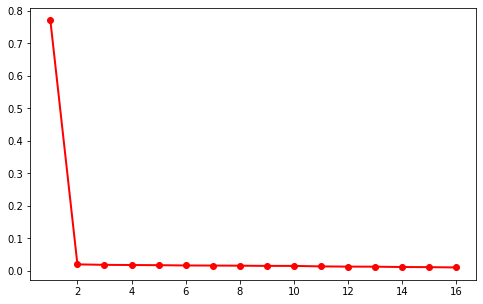

In [ ]:
# Following is the Scree polt of the learnt positional encoding

a = mymodel.pos_enc.squeeze()

U, S, V = torch.svd(a)
num_vars = 16
eigvals = (S**2 / torch.sum(S**2)).cpu().detach().numpy()
print(eigvals)
fig = plt.figure(figsize= (8,5))
sing_vals = np.arange(num_vars)+1
plt.plot(sing_vals, eigvals, 'ro-', linewidth = 2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


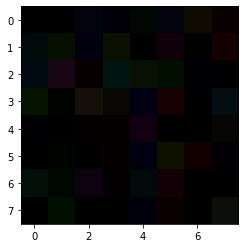

In [ ]:
# Visualizing the embedding weights

img = mymodel.embedding.weight.detach().cpu().reshape(512,8,8,3)
plt.imshow(img[25])
plt.show()

In [ ]:
#print(mymodel.pos_enc.max(dim=1))
#print(mymodel.pos_enc[0,0,:]*1000)





tensor([[11,  6,  3,  0, 13,  7,  1,  5,  6, 13,  8,  6,  5,  8,  4, 10,  3, 14,
          5,  5, 13, 10, 10, 15, 13,  1, 13,  2,  0,  8, 14, 15, 11, 15, 15,  5,
         10, 13, 10,  3,  3,  4,  9,  0, 12, 14, 13,  0,  6, 12,  6, 15,  9, 13,
         15,  1,  7,  1,  2,  9,  1,  4, 10, 14,  8,  4,  9,  1, 10,  9,  7,  7,
          9,  8, 11, 14, 13, 12, 13, 15,  0,  0,  1, 14,  0,  1, 14,  5,  4,  9,
          4,  1,  4,  0,  1, 13, 12, 15,  7,  3,  1,  4,  7,  2,  0,  7, 13, 11,
         12,  6,  3, 10,  8,  4,  0,  3,  7, 10,  7,  3, 14,  6,  2,  7,  2,  7,
          3, 10,  9,  3, 10,  8, 10,  3,  9,  5, 13, 12, 10,  5, 12,  3,  7,  0,
          2,  6, 12, 10,  4,  9, 14,  0, 13,  0, 13, 11,  1,  0,  4, 15, 10, 15,
          8,  6, 10,  2,  4, 12,  7,  2,  3,  2,  3,  4, 11,  2,  9, 11, 11,  2,
         14,  8, 12,  0, 12, 11, 14,  6,  8,  8,  1, 13,  7, 12, 14,  4, 11,  9,
         11,  5,  5,  0,  7, 13,  1,  3, 15,  1, 11, 10,  3,  8,  9, 14,  0,  2,
          0,  9, 15, 11,  8,

In [ ]:
# loading the testset
testset = torchvision.datasets.CIFAR10('data/',  transform = transform, download = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

Files already downloaded and verified


In [ ]:
# mymodel.load_state_dict(torch.load("/content/drive/MyDrive/studienarbeit/mnist_99percent"))
# testing:
running_loss_test = 0
acc = 0
mymodel.eval()
with torch.no_grad(): # does this line matter? we are not optimizing anyway.
  for images, labels in testloader:        
      # pre-processing the images            
      images, labels = images.to(device), labels.to(device)
      patched_images = images.permute(0,2,3,1).unfold(1,patch_size,patch_size).unfold(2,patch_size,patch_size).reshape(images.shape[0],int((Image_size/patch_size)**2),-1)
      
      # prediction
      output = mymodel(patched_images) 
      acc += accuracy(output,labels) 
      loss = criterion(output, labels)            
      running_loss_test += loss.item()


print( "testing loss: ", (running_loss_test/len(testloader)) )
print( "Test accuracy: %d" % (acc*100/(len(testloader))) )
    

testing loss:  0.7179089762518168
Test accuracy: 75
